<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Загрузка-и-подготовка-данны-к-анализу" data-toc-modified-id="Загрузка-и-подготовка-данны-к-анализу-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данны к анализу</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Импорт-и-изучение-данных" data-toc-modified-id="Импорт-и-изучение-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Импорт и изучение данных</a></span></li><li><span><a href="#Подготовка-данных-к-анализу" data-toc-modified-id="Подготовка-данных-к-анализу-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подготовка данных к анализу</a></span></li></ul></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Анализ-результатов-эксперимента" data-toc-modified-id="Анализ-результатов-эксперимента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ результатов эксперимента</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.
- *EventName* — название события;
- *DeviceIDHash* — уникальный идентификатор пользователя;
- *EventTimestamp* — время события;
- *ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка и подготовка данны к анализу 

###  Импорт библиотек 

In [1]:
import pandas as pd
import numpy as np

import math as mth
from scipy import stats as st

import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import date

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Импорт и изучение данных

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
# Посмотрим на данные и на общую информацию по ним:
display(df)
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:** доступна информация о 244126 событиях, пропущенных значений нет, время события указано не в удобном для анализа формате.

### Подготовка данных к анализу

In [4]:
#Для удобства изменим названия столбцов:
df.columns = ['event_name', 'user_id', 'event_time', 'exp_id']

In [5]:
#Добавим столбец с датой и временем в удобном формате и столбец с датой:
df['dt'] = pd.to_datetime(df['event_time'], unit = 's')
df['date'] = df['dt'].dt.date
display(df.head())

,event_name,user_id,event_time,exp_id,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [6]:
df.duplicated().sum()

413

Всего 394 дубликата или 0,16% от общего количества данных. Т.к. далее в воронках будем считать пользователей, которые хотя бы раз выполнили действие, дубликаты мешать не будут, поэтому их не трогаем. 

## Изучение и проверка данных

In [7]:
print('Число уникальных событий в логе: {}'.format(df['event_name'].nunique()))

Число уникальных событий в логе: 5


In [8]:
print('Число уникальных пользователей в логе: {}'.format(df['user_id'].nunique()))

Число уникальных пользователей в логе: 7551


In [9]:
print(
    'Среднее количество событий на одного пользователя {}'
    .format(df.groupby('user_id')['event_name'].agg('count').mean().round(2))
)
    

Среднее количество событий на одного пользователя 32.33


In [10]:
df['user_id'].value_counts().describe().round(2)

count    7551.00
mean       32.33
std        65.31
min         1.00
25%         9.00
50%        20.00
75%        37.50
max      2308.00
Name: user_id, dtype: float64

**Вывод:** Число уникальных пользователей в логе равно 7551, среднее количество событий на одного пользователя - 32.33, минимальное - 1, максимальное  - 2308

In [11]:
#Посмотрим на временной промежуток событий:
df[['dt','date']].describe()

,dt,date
count,244126,244126
unique,176654,14
top,2019-08-04 16:23:19,2019-08-01
freq,9,36229
first,2019-07-25 04:43:36,NaN
last,2019-08-07 21:15:17,NaN


Временной промежуток событий: с 25 июля 2019г. по 7 августа 2019г., всего 14 дней.

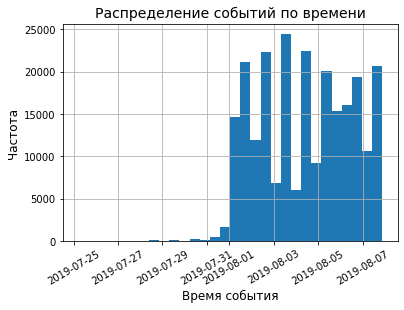

In [12]:
plt.title("Распределение событий по времени",size=14)
df['dt'].hist(bins=30)
plt.xlabel('Время события',size=12)
plt.xticks(rotation=30)
plt.ylabel('Частота',size=12)
plt.show()

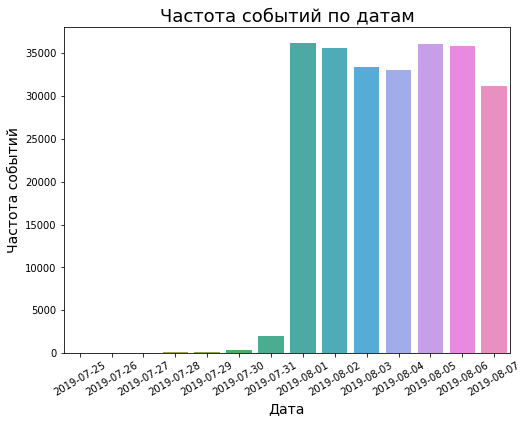

In [13]:
plt.figure(figsize=(8,6))
plt.title("Частота событий по датам",size=18)
sns.barplot(
    x=df['date'].value_counts().reset_index().sort_values('index')['index'],
    y=df['date'].value_counts().reset_index().sort_values('index')['date'])
plt.xlabel("Дата",size=14)
plt.xticks(rotation=30)
plt.ylabel("Частота событий",size=14)
plt.show()

**Вывод:** Как видим из графиков, в логе до 1 августа представлено мало событий, поэтому будем рассматривать данные о событиях, совершенных с 1 августа

In [14]:
df_new = df.loc[df['dt'] > '2019-07-31 23:59:59']

Проверим сколько событий и пользователей было в "отброшенных данных"

In [15]:
print(
    'Кол-во событий до 31.07.2019г. включительно равно {},\
    что составляет {:.2%}  от общего числа событий в логе'
    .format(
        len(df.loc[df['dt'] <= '2019-07-31 23:59:59']),
        len(df.loc[df['dt'] <= '2019-07-31 23:59:59']) / len(df['dt'])
    )
)

Кол-во событий до 31.07.2019г. включительно равно 2828,    что составляет 1.16%  от общего числа событий в логе


In [16]:
# найдем тех уникальных пользователей, которые были в "отброшенной" части и не появляются в "исследуемой" части:
j = 0
for i in df.loc[df['dt'] <= '2019-07-31 23:59:59']['user_id'].unique():
    if i not in df_new['user_id'].unique():
        j = j + 1
print(
    'Число уникальных пользователей в логе, которые совершали действия\
    в приложении до 31.07.2019г. включительно, но не совершали действий после 31.07.2019г. равно {}\
    или {:.2%} всех уникальных пользователей в логе'
    .format(j, j/df['user_id'].nunique())
)

Число уникальных пользователей в логе, которые совершали действия    в приложении до 31.07.2019г. включительно, но не совершали действий после 31.07.2019г. равно 17    или 0.23% всех уникальных пользователей в логе


Проверим, что остались пользователи все трёх экспериментальных групп

In [17]:
df_new.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Итак, у нас есть пользователи, вошедшие из всех трёх экспериментальных групп и разница в их количестве между группами колеблется в районе 2%.

## Воронка событий

In [18]:
# Посмотрим на события, которые есть в логе:
df_new['event_name'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64

Как и следовало ожидать, чаще всего в логе событие 'открытие главной страницы', реже всего - Tutorial

Теперь посчитаем, сколько уникальных пользователей совершали каждое из этих событий и их долю среди всех уникальных пользователей:

In [19]:
df_funnel = (
    df_new
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
)
df_funnel.columns = ['event_name','number_of users']
df_funnel['share_of_users'] = (
    df_funnel['number_of users'] / df_new['user_id'].nunique() * 100
).round(2)
df_funnel

,event_name,number_of users,share_of_users
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Некоторая часть пользователей не открывала основную страницу. Возможно были технические проблемы с отсылкой информации на сервер.

Событие Tutorial не будем учитывать при расчёте воронки, т.к. оно могло произойти в любой момент последовательности действий пользователя. Последовательность действия пользователя будем рассматривать как:
 - MainScreenAppear (перешёл на главную страницу);
 - OffersScreenAppear (перешёл на страницу товара);
 - CartScreenAppear (перешёл к оплате);
 - PaymentScreenSuccessful (заказ совершён)

In [20]:
df_funnel = df_funnel[df_funnel['event_name'] != 'Tutorial']

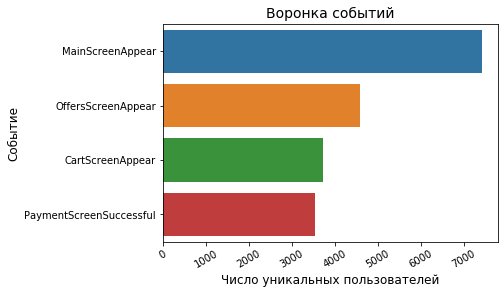

In [21]:
plt.figure(figsize=(6,4))
plt.title("Воронка событий",size=14)
sns.barplot(
    x=df_funnel['number_of users'],
    y=df_funnel['event_name']
)
plt.xlabel("Число уникальных пользователей",size=12)
plt.xticks(rotation=30)
plt.ylabel("Событие",size=12)
plt.show()

**Вывод:** между вторым и первым шагом мы теряем больше всего пользователей

Сосчитаем конверсию в следующий шаг:    

In [22]:
df_funnel['conversion_to_next_step'] = [100,1,1,1] 
for i in range(1,len(df_funnel)):
    df_funnel.loc[i,'conversion_to_next_step'] = (
        df_funnel.loc[i,'number_of users'] / df_funnel.loc[i-1,'number_of users'] * 100
    ).round(2)
df_funnel

,event_name,number_of users,share_of_users,conversion_to_next_step
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Сосчитаем также итоговую конверсию:

In [23]:
df_funnel['conversion'] = (
    df_funnel['number_of users'] / df_funnel.loc[0,'number_of users'] * 100
).round(2)
df_funnel

,event_name,number_of users,share_of_users,conversion_to_next_step,conversion
0,MainScreenAppear,7419,98.47,100.00,100.00
1,OffersScreenAppear,4593,60.96,61.91,61.91
2,CartScreenAppear,3734,49.56,81.30,50.33
3,PaymentScreenSuccessful,3539,46.97,94.78,47.70


**Вывод:** всего 50.33% дошли от первого шага до оплаты и только 47.7% завершили заказ успешно. На этапе перехода к OffersScreen теряем больше всего пользователей - 38.09%

## Анализ результатов эксперимента

Вспомним сколько пользователей в каждой экспериментальной группе:

In [24]:
df_new.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [25]:
# Посчитаем количество уникальных пользователей для каждого события в каждой группе:
df_new = df_new[df_new['event_name'] != 'Tutorial']
df_new.pivot_table(
    index='event_name',
    columns='exp_id',
    values='user_id',
    aggfunc='nunique'
)

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181


In [26]:
# Напишем функцию для расчёта долей для каждой группы для каждого события и проверки гипотез о равенстве долей:
def abtest(df,groups,alpha,name1,name2):
    print('\033[1m' + 'Группы:', name1,name2)
    print('\033[0m')
    users = [df.query('exp_id == @group')['user_id'].nunique() for group in groups]
    for event in df['event_name'].unique():
        events = [df.query('exp_id == %d and event_name == "%s"' % (group,event))['user_id'].nunique() \
                  for group in groups]   
        
        p1 = events[0] / users[0]
        p2 = events[1] / users[1]
       
        p_combined = sum(events) / sum(users)
        difference = p1-p2
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1])
        )
        
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие',event)
        print('Доли пользователей, совершивших событие',p1, 'и', p2)
        print('Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны')
        print('Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны')
        print('p_value равно', p_value)
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            ) 

        print('-------------')
        print('')

In [27]:
# Проверим гипотезу, что между долями контрольных групп нет разницы:
abtest(df_new,[246,247], 0.05, 'Первая контрольная','и вторая контрольная')


Группы: Первая контрольная и вторая контрольная

Событие MainScreenAppear
Доли пользователей, совершивших событие 0.9867096254530809 и 0.9856687898089171
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие OffersScreenAppear
Доли пользователей, совершивших событие 0.6210229561014902 и 0.6050955414012739
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие CartScreenAppear
Доли пользователей, совершивших событие 0.5098670962545309 и 0.4928343949044586
Нулевая гипотеза:

**Вывод:** Разделение контрольных групп сделано корректно.

In [28]:
# Проверим гипотезу, что между долями первой контрольной группы и экспериментальной группы нет разницы:
abtest(df_new,[246,248], 0.05, 'Первая контрольная','и экспериментальная')

Группы: Первая контрольная и экспериментальная

Событие MainScreenAppear
Доли пользователей, совершивших событие 0.9867096254530809 и 0.9834319526627219
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие OffersScreenAppear
Доли пользователей, совершивших событие 0.6210229561014902 и 0.6039447731755424
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие CartScreenAppear
Доли пользователей, совершивших событие 0.5098670962545309 и 0.48520710059171596
Нулевая гипотеза:

In [29]:
# И гипотезу, что между долями второй контрольной группы и экспериментальной группы нет разницы:
abtest(df_new,[247,248], 0.05, 'Вторая контрольная','и экспериментальная')

Группы: Вторая контрольная и экспериментальная

Событие MainScreenAppear
Доли пользователей, совершивших событие 0.9856687898089171 и 0.9834319526627219
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие OffersScreenAppear
Доли пользователей, совершивших событие 0.6050955414012739 и 0.6039447731755424
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие CartScreenAppear
Доли пользователей, совершивших событие 0.4928343949044586 и 0.48520710059171596
Нулевая гипотеза: 

In [30]:
# Теперь проверим гипотезу, что между долями двух контрольных групп и экспериментальной группы нет разницы:
df_allA = df_new
df_allA['exp_id'] = df_new['exp_id'].replace(246, 300)
df_allA['exp_id'] = df_new['exp_id'].replace(247, 300)
abtest(df_new,[300,248], 0.05, 'Объединённая контрольная', 'и экспериментальная')

Группы: Объединённая контрольная и экспериментальная

Событие MainScreenAppear
Доли пользователей, совершивших событие 0.9861861861861861 и 0.9834319526627219
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие OffersScreenAppear
Доли пользователей, совершивших событие 0.613013013013013 и 0.6039447731755424
Нулевая гипотеза: доли пользователей, совершивших это событие, в данных группах равны
Альтернативная гипотеза: доли пользователей, совершивших это событие, в данных группах не равны
p_value равно 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-------------

Событие CartScreenAppear
Доли пользователей, совершивших событие 0.5013013013013013 и 0.48520710059171596
Нулевая гипо

**Вывод:** эксперимент не удался, статистически значимых отличий между группами нет.

## Выводы

1. Доступна информация о 244126 совершённых событиях, пропущенных значений нет, время события указано не в удобном для анализа формате, поэтому в датафрейм добавлены столбцы с временем и датой, и датой в формате datetime.
2. В логе 5 уникальных событий и 7551 уникальных пользователей. Среднее количество событий на одного пользователя 32.33.
3. Т.к. событий до 1 августа 2019г. в логе представлено мало, для дальнейшего анализа взяли данные по совершенным событиям с 1 августа 2019г. 
4. Многие пользователи остаются на этапе 'открытие главной страницы', туториал открывают редко. Некоторая часть пользователей не открывала главную страницу. Возможно были технические проблемы с отсылкой информации на сервер.
5. При анализе воронки определили, что при переходе с главной на страницу товара было потеряно больше всего пользователей 38.09%. Всего 50.33% пользователей дошли от первого шага (главная страница) до оплаты и только 47.7% завершили заказ успешно.
6. На основании проверки гипотезы сделали вывод, что контрольные группы разделены корректно.
7. А/В-тест показал, что эксперимент не удался, шрифт менять не рекомендуется.